In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn import preprocessing
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import matplotlib
import shap

shap.initjs()

# Summary as of 11/21

#### My hypothesis: we can use the origin, price, and ingredient to predict which are good wine

1. Used the same file as Pedro's
2. Built a Gradient Boosting model using these variables ['price', 'country', 'province', 'variety', 'rating']
3. The accuracy_score was 65.78% without tuning model
4. My model is weaker than Pedro's 82.97%
5. A possible conclusion can be: the origin, price, and ingredient are not good predictors for wine's rating. To be more applicable, when you go to a wine shop, don't choose a wine based on its origin, ingredient or price. Just follow your heart. Or just follow the recommendation made by someone you can trust. 
6. Tried to use SHAP to exlain the feature importance. Plotted some cool stuff but none of them make sense.

#### My second hypothesis: wine from different area (in this dataset, I mean province) have different falvors
1. I did lift analysis like what we did in text analysis to match flavors and area (province). I did top 5 province but we can do more or we can look at specific area you are interested in. 
2. Wine from California taste dry, more like pineapple, smoky, blackberry
3. Wine from Washington taste like coffee and herb 
4. Wine from Bordeaux taste like wood (the lift is 5.7, crazy!!!)
5. Wine from Tuscany taste like berry and raspberry
6. Application is that next time when you are talkingabout wine with your friends, you can claim these are all backed by data analysis


In [3]:
# winemag-data_first150k.csv
data150 = pd.read_csv('winemag-data_first150k.csv')
data150['rating'] = 'bad'
data150.loc[data150['points'].astype(int) > 87.5,'rating'] = 'neutral'
data150.loc[data150['points'].astype(int) > 90,'rating'] = 'good'

#### I'm going to use Gradient Boosting to train a calssifier
The variables will be: 

1. catgorical: country, province, variety(grapes)
2. numerical: price

In [3]:
def sumna(se):
    return(np.sum(se.isna()))
data150.apply(sumna)/data150.shape[0]

Unnamed: 0     0.000000
country        0.000033
description    0.000000
designation    0.303021
points         0.000000
price          0.090737
province       0.000033
region_1       0.166037
region_2       0.596151
variety        0.000000
winery         0.000000
rating         0.000000
dtype: float64

## Data cleaning
1. I will get rid of missing rows
2. Don't feel like we need to process outliers in features

In [4]:
variables = ['price', 'country', 'province', 'variety', 'rating']

data = data150[variables].dropna()

In [5]:
# check nan values.
data.apply(sumna)/data.shape[0]

price       0.0
country     0.0
province    0.0
variety     0.0
rating      0.0
dtype: float64

In [6]:
data.sort_values(['price'], ascending=False)

,price,country,province,variety,rating
34920,2300.0,France,Bordeaux,Bordeaux-style Red Blend,good
13318,2013.0,US,California,Chardonnay,good
34922,1900.0,France,Bordeaux,Bordeaux-style Red Blend,good
51886,1400.0,France,Champagne,Chardonnay,good
26296,1400.0,France,Champagne,Chardonnay,good
83536,1400.0,France,Champagne,Chardonnay,good
34939,1300.0,France,Bordeaux,Bordeaux-style Red Blend,good
34942,1200.0,France,Bordeaux,Bordeaux-style Red Blend,good
10651,1100.0,Austria,Wachau,Grüner Veltliner,good
34927,1100.0,France,Bordeaux,Bordeaux-style Red Blend,good


## Encode categorical variables

In [7]:
cat_variables = ['country', 'province', 'variety'] # turned out I don't need to encode labels

le = preprocessing.LabelEncoder()

for col in cat_variables:
    data[col] = le.fit_transform( data[col] )

## Setup training data

In [8]:
X = data.iloc[:,:-1]
y = data['rating']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

## Train a model

In [9]:
%%time
bst = lgb.LGBMClassifier(n_estimators = 3000)
bst.fit(X_train.values, y_train.values)

Wall time: 16.7 s


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=3000, n_jobs=-1, num_leaves=31, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [10]:
## Training accuracy
predictions = bst.predict(X_train)

print(confusion_matrix(y_train,predictions))
print(classification_report(y_train,predictions))
print(accuracy_score(y_train, predictions))

[[45546  2718  5481]
 [ 3244 15014  4109]
 [11456  4805 17411]]
              precision    recall  f1-score   support

         bad       0.76      0.85      0.80     53745
        good       0.67      0.67      0.67     22367
     neutral       0.64      0.52      0.57     33672

    accuracy                           0.71    109784
   macro avg       0.69      0.68      0.68    109784
weighted avg       0.70      0.71      0.70    109784

0.7102218902572324


In [11]:
## Testing accuracy
predictions = bst.predict(X_test)

print(confusion_matrix(y_test,predictions))
print(classification_report(y_test,predictions))
print(accuracy_score(y_test, predictions))

[[10897   771  1776]
 [  935  3424  1322]
 [ 3170  1417  3734]]
              precision    recall  f1-score   support

         bad       0.73      0.81      0.77     13444
        good       0.61      0.60      0.61      5681
     neutral       0.55      0.45      0.49      8321

    accuracy                           0.66     27446
   macro avg       0.63      0.62      0.62     27446
weighted avg       0.65      0.66      0.65     27446

0.657837207607666


## Comment on model
1. It looks loke a bit overfitting 
2. It's weaker than Pedro's model

## Tried to plot the feature importance...

Text(0.5, 1.0, 'Gradient Boosting Model Importance')

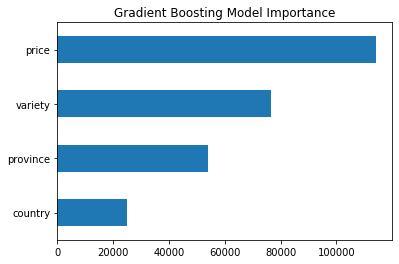

In [12]:
importance = pd.Series(bst.feature_importances_, index=X_train.columns)
importance.sort_values().plot.barh()        
plt.title('Gradient Boosting Model Importance')

## Tried SHAP to show feature importance
https://github.com/slundberg/shap

Refer to: https://slundberg.github.io/shap/notebooks/tree_explainer/Census%20income%20classification%20with%20LightGBM.html

Rfeer (Chinese): https://zhuanlan.zhihu.com/p/64799119

In [13]:
# %%time
# explainer = shap.TreeExplainer(bst)

Wall time: 9.71 s


In [14]:
# %%time
# shap_values = explainer.shap_values(X_train)

Wall time: 11min 29s


In [16]:
## This is only for first sample
# shap.force_plot(explainer.expected_value[1], shap_values[1][0,:], X_train.iloc[0,:])

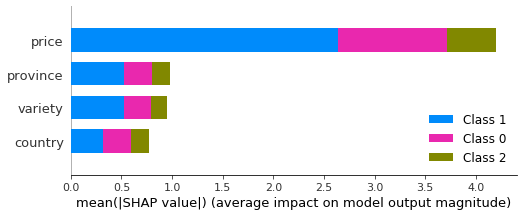

In [21]:
# shap.summary_plot(shap_values, X_train)

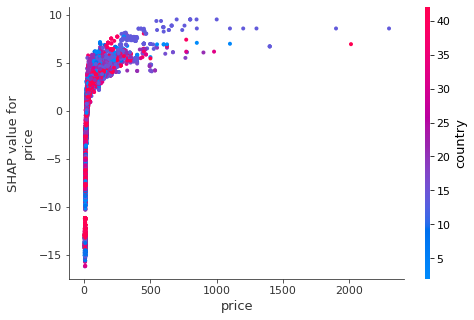

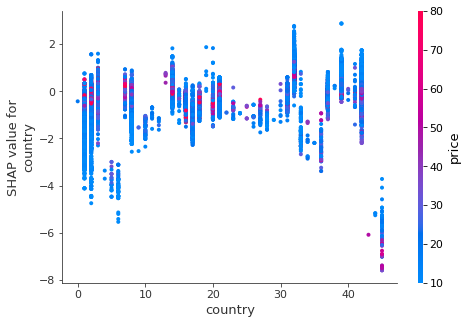

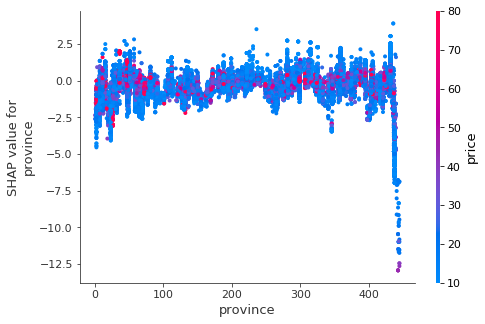

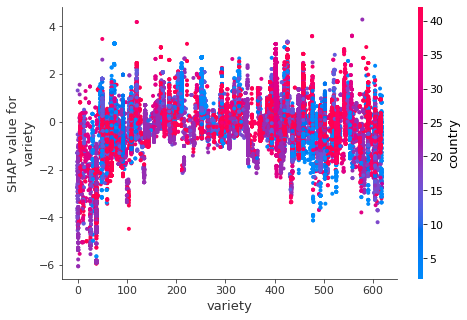

In [20]:
# for name in X_train.columns:
#     shap.dependence_plot(name, shap_values[1], X_train, display_features=X_train)


# Hypothesis 2
## Attributes extraction

In [4]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from itertools import chain
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

df = data150

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\spong\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\spong\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\spong\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Preprocess

In [6]:
%%time
# tokenization
df['tokens'] = df['description'].map(nltk.word_tokenize)
df['bigrams'] = df['tokens'].map(lambda x: list(nltk.bigrams(x)))
df['trigrams'] = df['tokens'].map(lambda x: list(nltk.trigrams(x)))
df['tokens'] = df['tokens'].map(lambda x: set(x))

# lemmatization
lemmatizer = WordNetLemmatizer()
df['lemmatized'] = df ['tokens'].map(lambda x: [lemmatizer.lemmatize(word) for word in x])
df['lemmatized'] = df['lemmatized'].map(lambda x: set(x))

# remove stop words
stop_words = set(stopwords.words('english'))
df['processed'] = df['lemmatized'].map(lambda x: [word for word in x if word.lower() not in stop_words])

# remove punctuations
punc = "!\"#$%&'()*+,-./:;<=>?@[\]^_`{|}~..."
df['processed'] = df['processed'].map(lambda x: [word for word in x if word.lower() not in punc])

# remove some other stuff and return lower case
others = ["''", "``", "n't", "l", "oh", "lol", "'m", "'s"]
df['processed'] = df['processed'].map(lambda x: [word.lower() for word in x if word.lower() not in others])

Wall time: 1min 23s


In [7]:
all_words = pd.Series(chain(*list(df['processed'])))
word_frequency = all_words.value_counts()

## Choose some flavors

I choose these flavors from top 400 most frequent word.

In [8]:
flavors = 'fruit cherry acidity spice dry rich sweet berry blackberry oak vanilla apple raspberry chocolate citrus peach herb spicy pear pineapple creamy lemon wood smoky tobacco coffee orange melon strawberry grapefruit floral meat cinnamon'.split()
flavors

['fruit',
 'cherry',
 'acidity',
 'spice',
 'dry',
 'rich',
 'sweet',
 'berry',
 'blackberry',
 'oak',
 'vanilla',
 'apple',
 'raspberry',
 'chocolate',
 'citrus',
 'peach',
 'herb',
 'spicy',
 'pear',
 'pineapple',
 'creamy',
 'lemon',
 'wood',
 'smoky',
 'tobacco',
 'coffee',
 'orange',
 'melon',
 'strawberry',
 'grapefruit',
 'floral',
 'meat',
 'cinnamon']

In [9]:
a = 'fruit'
b = 'California'
print(np.sum((df['processed'].map(lambda x: a in x)) & (df['province'] == b)))
print(sum(df['processed'].map(lambda x: a in x)))
print(sum(df['province'] == b))
# df['processed'].map(lambda x: a in x)


10330
60584
44508


In [10]:
def lift(a, b):
    N = df['processed'].shape[0]
    N_ab = sum((df['processed'].map(lambda x: a in x)) & (df['province'] == b))
    N_a = sum(df['processed'].map(lambda x: a in x))
    N_b = sum(df['province'] == b)
#     print('N', 'N_ab', 'N_a', 'N_b')
#     print(N, N_ab, N_a, N_b)
    if N_a*N_b == 0:
        return(None)
    else:
        return(N*N_ab/(N_a*N_b))

Then I choose 5 province I want to look at

In [11]:
number_of_province = 5
provinces = df['province'].value_counts().iloc[:number_of_province].index.values
provinces

provinces = pd.DataFrame(provinces, columns=['province'])
for flavor in flavors:
    print(flavor)
    provinces[flavor] = provinces['province'].map(lambda x: lift(flavor, x))
provinces = provinces.set_index('province')
provinces.T

fruit
cherry
acidity
spice
dry
rich
sweet
berry
blackberry
oak
vanilla
apple
raspberry
chocolate
citrus
peach
herb
spicy
pear
pineapple
creamy
lemon
wood
smoky
tobacco
coffee
orange
melon
strawberry
grapefruit
floral
meat
cinnamon


province,California,Washington,Tuscany,Bordeaux,Northern Spain,Mendoza Province,Oregon,Burgundy,Piedmont,Veneto
fruit,0.578202,1.612798,1.010050,1.659204,0.919197,0.872096,1.575965,1.635968,1.099851,1.046301
cherry,1.541238,0.943933,2.057002,0.065948,0.917956,0.687698,1.013515,0.227189,1.553294,1.056621
acidity,1.082114,0.303187,0.515780,1.680284,0.639073,0.575505,0.385468,2.327530,0.837783,0.440501
spice,0.823622,0.756382,2.262905,0.708379,0.875089,0.740929,0.666335,0.688922,2.172401,1.682794
dry,2.094528,0.273638,0.195305,1.081490,0.620121,0.382700,0.289216,0.534427,0.132353,0.499061
rich,1.486151,0.466539,0.786263,1.573435,0.337160,0.467926,0.319128,1.672249,0.627055,0.576848
sweet,1.393380,0.766420,0.727488,0.866772,0.797497,1.325851,0.472489,0.522466,0.775374,1.272527
berry,0.410713,1.116074,1.795200,0.894261,2.444871,2.732813,0.769529,0.665793,2.317019,0.792499
blackberry,1.914715,0.303239,1.174187,0.596572,1.115384,1.517325,0.169363,0.048357,0.871128,0.657253
oak,1.848095,1.079807,0.818349,0.047562,1.288955,1.222464,0.876162,0.078713,0.787054,0.562429


In [12]:
for province in provinces.index:
    print("Wine from {} taste like:".format(province), "==============")
    print(provinces.T[province].sort_values(ascending=False)[:5])

Wine from California taste like: ==============
dry           2.094528
pineapple     1.965826
smoky         1.935283
blackberry    1.914715
oak           1.848095
Name: California, dtype: float64
Wine from Washington taste like: ==============
coffee        2.650685
herb          2.409139
strawberry    1.873638
fruit         1.612798
spicy         1.558598
Name: Washington, dtype: float64
Wine from Tuscany taste like: ==============
tobacco    3.788644
meat       2.617308
spice      2.262905
cherry     2.057002
coffee     1.914722
Name: Tuscany, dtype: float64
Wine from Bordeaux taste like: ==============
wood       5.693182
acidity    1.680284
fruit      1.659204
rich       1.573435
smoky      1.261768
Name: Bordeaux, dtype: float64
Wine from Northern Spain taste like: ==============
berry        2.444871
raspberry    2.004492
tobacco      1.827583
coffee       1.660355
vanilla      1.597128
Name: Northern Spain, dtype: float64
Wine from Mendoza Province taste like: ==============
ber

#### Look at texas'wine

In [20]:
provinces = ['Texas']

provinces = pd.DataFrame(provinces, columns=['province'])
for flavor in flavors:
    print(flavor)
    provinces[flavor] = provinces['province'].map(lambda x: lift(flavor, x))
provinces = provinces.set_index('province')
provinces.T

for province in provinces.index:
    print("Wine from {} taste like:".format(province), "==============")
    print(provinces.T[province].sort_values(ascending=False)[:5])

fruit
cherry
acidity
spice
dry
rich
sweet
berry
blackberry
oak
vanilla
apple
raspberry
chocolate
citrus
peach
herb
spicy
pear
pineapple
creamy
lemon
wood
smoky
tobacco
coffee
orange
melon
strawberry
grapefruit
floral
meat
cinnamon
Wine from Texas taste like: ==============
spicy      4.779676
floral     3.795072
smoky      3.639967
vanilla    3.408011
pear       2.327234
Name: Texas, dtype: float64


# ====================================================
# Below are previous work

Based on https://www.kaggle.com/zynicide/wine-reviews, the data was scraped from WineEnthusiast during the week of November 22nd, 2017. 

We can also  find the scraper if we want to update the data.

#### Looks like 'winemag-data-130k-v2.csv' has more interesting variables such as title and taster name, I'm going to use it.

Some notes for vaurables
1. description - A few sentences from a sommelier describing the wine's taste, smell, look, feel, etc.
2. designation - The vineyard within the winery where the grapes that made the wine are from
3. title - The title of the wine review (which often contains the vintage, if you are interested in that information)
4. variety - The type of grapes used to make the wine (e.g. "Pinot Noir")

Can find the rest here: 
https://knowledge.domo.com/Training/Self-Service_Training/Onboarding_Resources/Fun_Sample_Datasets

#### References
1. Wine review's Understanding - Pythonic EDA (cool graphs) - https://www.kaggle.com/kabure/wine-review-s-understanding-pythonic-eda 
2. seaborn example - https://www.kaggle.com/residentmario/plotting-with-seaborn 

In [2]:
df = pd.read_csv('winemag-data-130k-v2.csv')
df.shape

(129971, 14)

In [3]:
df.head()

,Unnamed: 0,country,description,designation,points,price,province,region_1,region_2,taster_name,taster_twitter_handle,title,variety,winery
0,0,Italy,"Aromas include tropical fruit, broom, brimston...",Vulkà Bianco,87,NaN,Sicily & Sardinia,Etna,NaN,Kerin O’Keefe,@kerinokeefe,Nicosia 2013 Vulkà Bianco (Etna),White Blend,Nicosia
1,1,Portugal,"This is ripe and fruity, a wine that is smooth...",Avidagos,87,15.0,Douro,NaN,NaN,Roger Voss,@vossroger,Quinta dos Avidagos 2011 Avidagos Red (Douro),Portuguese Red,Quinta dos Avidagos
2,2,US,"Tart and snappy, the flavors of lime flesh and...",NaN,87,14.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Rainstorm 2013 Pinot Gris (Willamette Valley),Pinot Gris,Rainstorm
3,3,US,"Pineapple rind, lemon pith and orange blossom ...",Reserve Late Harvest,87,13.0,Michigan,Lake Michigan Shore,NaN,Alexander Peartree,NaN,St. Julian 2013 Reserve Late Harvest Riesling ...,Riesling,St. Julian
4,4,US,"Much like the regular bottling from 2012, this...",Vintner's Reserve Wild Child Block,87,65.0,Oregon,Willamette Valley,Willamette Valley,Paul Gregutt,@paulgwine,Sweet Cheeks 2012 Vintner's Reserve Wild Child...,Pinot Noir,Sweet Cheeks


### I wonder the price and points have any correlation, if variety is given.

In [4]:
winery = df['winery'].value_counts()
winery.head()

Wines & Winemakers    222
Testarossa            218
DFJ Vinhos            215
Williams Selyem       211
Louis Latour          199
Name: winery, dtype: int64

In [5]:
len(winery)

16757

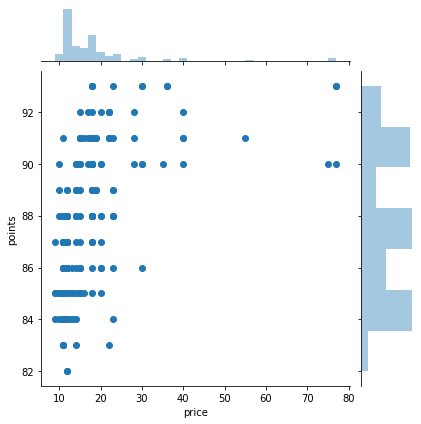

In [6]:
data = df[ df['winery'] == 'Wines & Winemakers']
sns.jointplot(x='price', y='points', data=data)

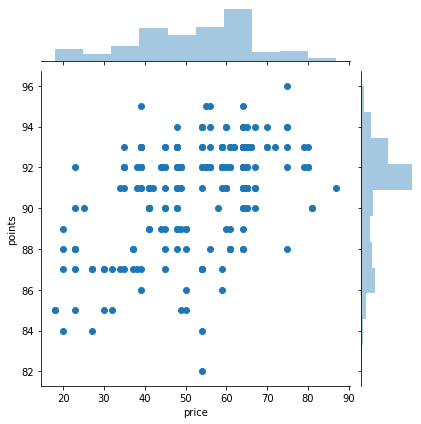

In [7]:
data = df[ df['winery'] == 'Testarossa']
sns.jointplot(x='price', y='points', data=data)

In [8]:
Testarossa = df[ df['winery'] == 'Testarossa']
Testarossa['variety'].value_counts()

Pinot Noir         122
Chardonnay          85
Syrah                8
Red Blend            1
Sauvignon Blanc      1
Meritage             1
Name: variety, dtype: int64

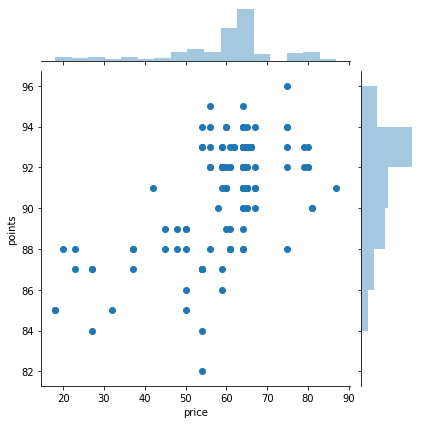

In [9]:
Testarossa_PN = Testarossa[ Testarossa['variety'] == 'Pinot Noir']
sns.jointplot(x='price', y='points', data=Testarossa_PN)

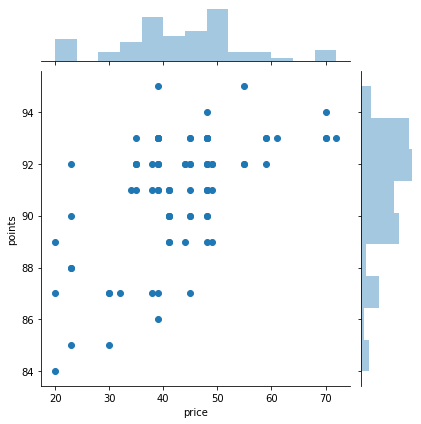

In [10]:
Testarossa_PN = Testarossa[ Testarossa['variety'] == 'Chardonnay']
sns.jointplot(x='price', y='points', data=Testarossa_PN)

### I wonder the price and points have any correlation, if variety is given.

In [11]:
variety = df['variety'].value_counts()
variety.head()

Pinot Noir                  13272
Chardonnay                  11753
Cabernet Sauvignon           9472
Red Blend                    8946
Bordeaux-style Red Blend     6915
Name: variety, dtype: int64

In [12]:
len(variety)

707

In [13]:
Pinot_Noir = df[ df['variety'] == 'Pinot Noir' ]

Text(0, 0.5, 'points')

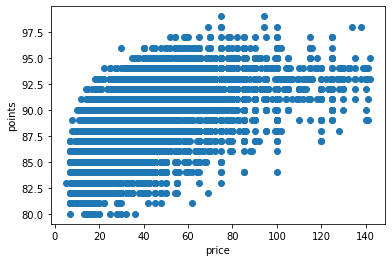

In [14]:
# take away outlier and try again
std = Pinot_Noir['price'].std()
mean = Pinot_Noir['price'].mean()
Pinot_Noir_no_outlier = Pinot_Noir[ (Pinot_Noir['price'] <= mean + 2*std) & (Pinot_Noir['price'] >= mean - 2*std) ]

plt.scatter(Pinot_Noir_no_outlier['price'],Pinot_Noir_no_outlier['points'])
plt.xlabel('price')
plt.ylabel('points')

In [36]:
Pinot_Noir_no_outlier.shape[0]/Pinot_Noir.shape[0]

0.9482368896925859

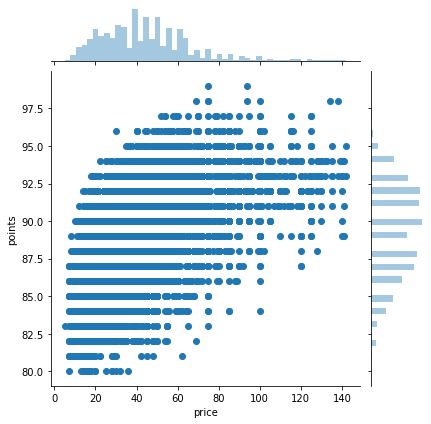

In [15]:
sns.jointplot(x='price', y='points', data=Pinot_Noir_no_outlier)

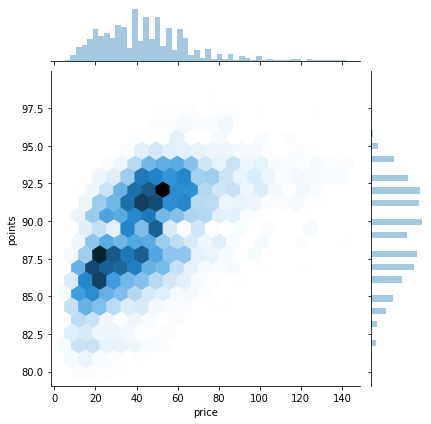

In [16]:
sns.jointplot(x='price', y='points', data=Pinot_Noir_no_outlier, kind='hex', gridsize=20)

It looks like they might have a positvie correlation. But not very clear.

### I wonder the price and points have any correlation, if province is given.

In [17]:
province = df['province'].value_counts()
province.head()

California    36247
Washington     8639
Bordeaux       5941
Tuscany        5897
Oregon         5373
Name: province, dtype: int64

In [18]:
len(province)

425

Text(0, 0.5, 'points')

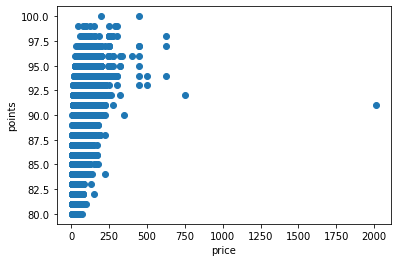

In [19]:
California = df[ df['province'] == 'California' ]
subset = California

plt.scatter(subset['price'],subset['points'])
plt.xlabel('price')
plt.ylabel('points')

In [20]:
California['variety'].value_counts()[:5]

Pinot Noir            6896
Cabernet Sauvignon    5693
Chardonnay            5183
Zinfandel             2639
Syrah                 1870
Name: variety, dtype: int64

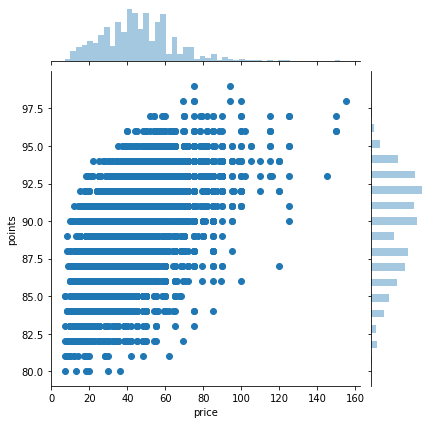

In [21]:
California_NP = California[ California['variety'] == 'Pinot Noir']
sns.jointplot(x='price', y='points', data=California_NP)

Text(0, 0.5, 'points')

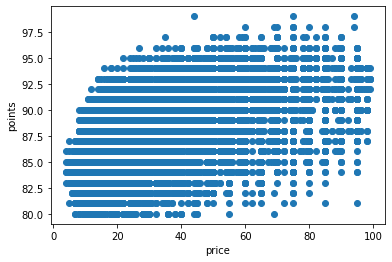

In [22]:
# take away outlier and try again
std = subset['price'].std()
mean = subset['price'].mean()
subset = subset[ (subset['price'] <= mean + 2*std) & (subset['price'] >= mean - 2*std) ]

plt.scatter(subset['price'],subset['points'])
plt.xlabel('price')
plt.ylabel('points')

### Extract vintage from title

In [23]:
len(df['title'].value_counts())

118840

In [24]:
sum(df['title'].isnull())

0

In [25]:
[int(x) for x in re.findall( '20\d\d|19\d\d|18\d\d|17\d\d', "Bella Victorian Vineyard 2007 Kimberly Cabernet Sauvignon (Napa Valley)")]

[2007]

In [26]:
def get_vintage(title):
    output = re.findall('20[0-1]\d|19\d\d', title)
    if len(output) > 0:
        output = [ int(x) for x in output]
        return(max(output))
    else:
        return(np.nan)
df['vintage'] = df['title'].map(get_vintage)

In [27]:
df['vintage'].max()

2017.0

In [28]:
df['vintage'].min()

1904.0

Since there are little data before 1997, we should focus on year since 1997

Text(0.5, 1.0, 'data count per year')

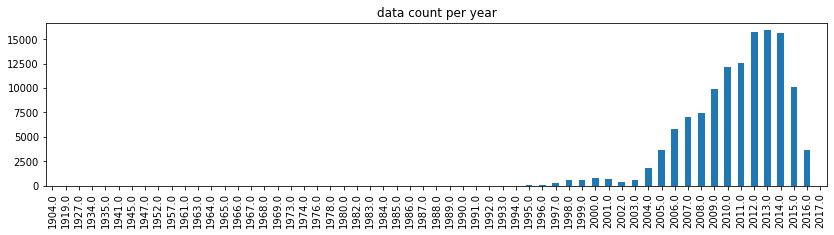

In [29]:
df['vintage'].value_counts().sort_index().plot.bar(figsize = (14,3))
plt.title('data count per year')

Text(0.5, 1.0, 'median price for each year')

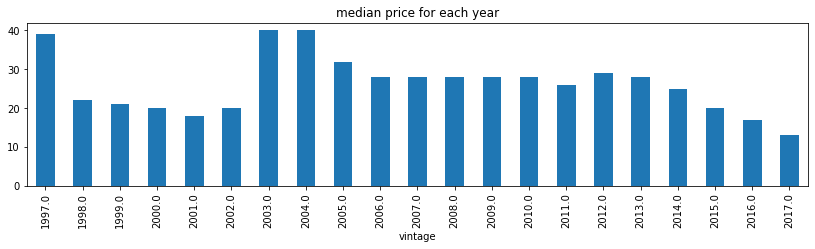

In [30]:
df[df['vintage']>=1997].groupby(by=['vintage'])['price'].median().plot.bar(figsize = (14,3))
plt.title('median price for each year')

Text(0.5, 1.0, 'max price for each year')

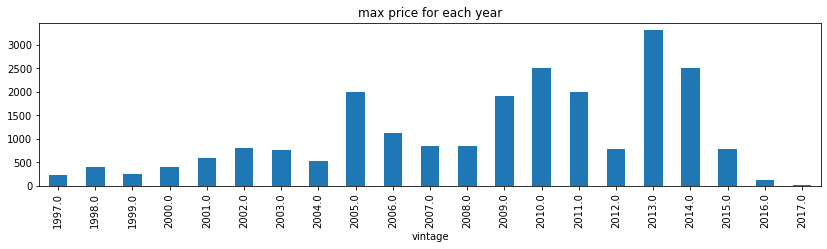

In [31]:
df[df['vintage']>=1997].groupby(by=['vintage'])['price'].max().plot.bar(figsize = (14,3))
plt.title('max price for each year')